# Social Computing/Social Gaming - Summer 2021
# Exercise Sheet 4 - Social Tie Strength

In this exercise, you are going to predict Tie Strength in a social network using the method explained in the paper _E. Gilbert and K. Karahalios: Predicting Tie Strength With Social Media_ [1], of which a short introduction is provided to you in the exercise files. According to Mark Granovetter, the strength of a tie between two persons is a combination of the amount of time, the emotional intensity, the intimacy and the reciprocal services which characterize it. Using variables that describe these categories, we want to find out how much each one of these features contributes in order to predict the strength of ties not previously known.<br>
An important prerequisite to this exercise is understanding the basic concept of linear regression models. As mentioned in the lecture, a recommended reading is chapter 3 of _C. Bishop: Pattern Recognition and Machine Learning_ [2], which you can find on [Moodle](https://www.moodle.tum.de/) [3].


### Tie Strength Prediction

In social network analysis, the Tie Strength between two people measures how strong their relationship is. The paper above describes the procedure of deriving available information (different variables) about a connection between two persons from an online social network and using it in order to discover how close they are. The ultimate goal is to build a model using the given information, finding out which variables account most for the Tie Strength and using that model later on to predict social Tie Strength when only the predictive (or explanatory) variables are available. Before being able to predict anything, we need to find out whether the given variables are suitable for prediction in the first place. This can be done via creating and evaluating a **multiple linear regression model**. 'Multiple' here refers to having more than one predictive variable in an regression model.<br>
In the paper mentioned above, 67 variables where used in the linear model to predict the Tie Strength. In our simplified model, we are going to use only 10 predictive variables which are:

<br>
<div>
<img style="margin-left: 5em" src="img/Variables.PNG" width="400"/>
</div>
<br>  






We are going to use a simplified form of the paper's linear model:
$$y_i = \alpha + \beta X_i + \epsilon_i$$

where $y_i$ is the dependent variable (also referred to as target value, which is the Tie Strength in our case) of the $i$-th friend of a person. $X_i$ is the predictive vector, containing the (predictive) variables listed above. $\alpha$ and $\beta$ are the model's parameters, where $\alpha$ is the intercept/bias, $\beta$ the coefficient vector containing coefficients for each predictive variable, and $\epsilon$ the prediction error. The regression problem boils down to calculating the model's parameters given a certain ground truth; meaning that for some connections, the Tie Strength has to be already known for building the model. That way, the unknown Tie Strengths can be predicted using the regression model by simply inserting the values into the vector. The coefficients for each predictive variable will show us the importance of the respective variable for the social Tie Strength.

### Problem Overview

The input to your Python program is a directed social network _SocialGraph.gml_. As the first step, you will visualize the graph with NetworkX to get an overview over the data.

In practice, the ground truth (Tie Strength in our case) is usually retrieved by participant's answers to surveys on how strong their relationship is with another person - this is why the graph is directed: two people might have varying views. The ground truth is available in the file. About 70% of the edges have valid values for the `tieStrength` variable, which should be used for training. For about 30% of the edges, the variable is set to -1 (equivalent to unknown). These represent the prediction set for which the Tie Strength should be predicted using the linear regression model later. But first, that model needs to be computed and checked for its goodness of fit.

## Task 4.1: Preparations

### a) Imports and Visualization
First, needed libraries and the graph's .gml file have to be imported. The social graph is visualized in order to get an idea what the network actually looks like.
Inspect the plotted graph. **Describe** shortly, what the graph's visualization is telling you, and if there are any problems with this representation. **Any ideas** on how to improve the visualization?

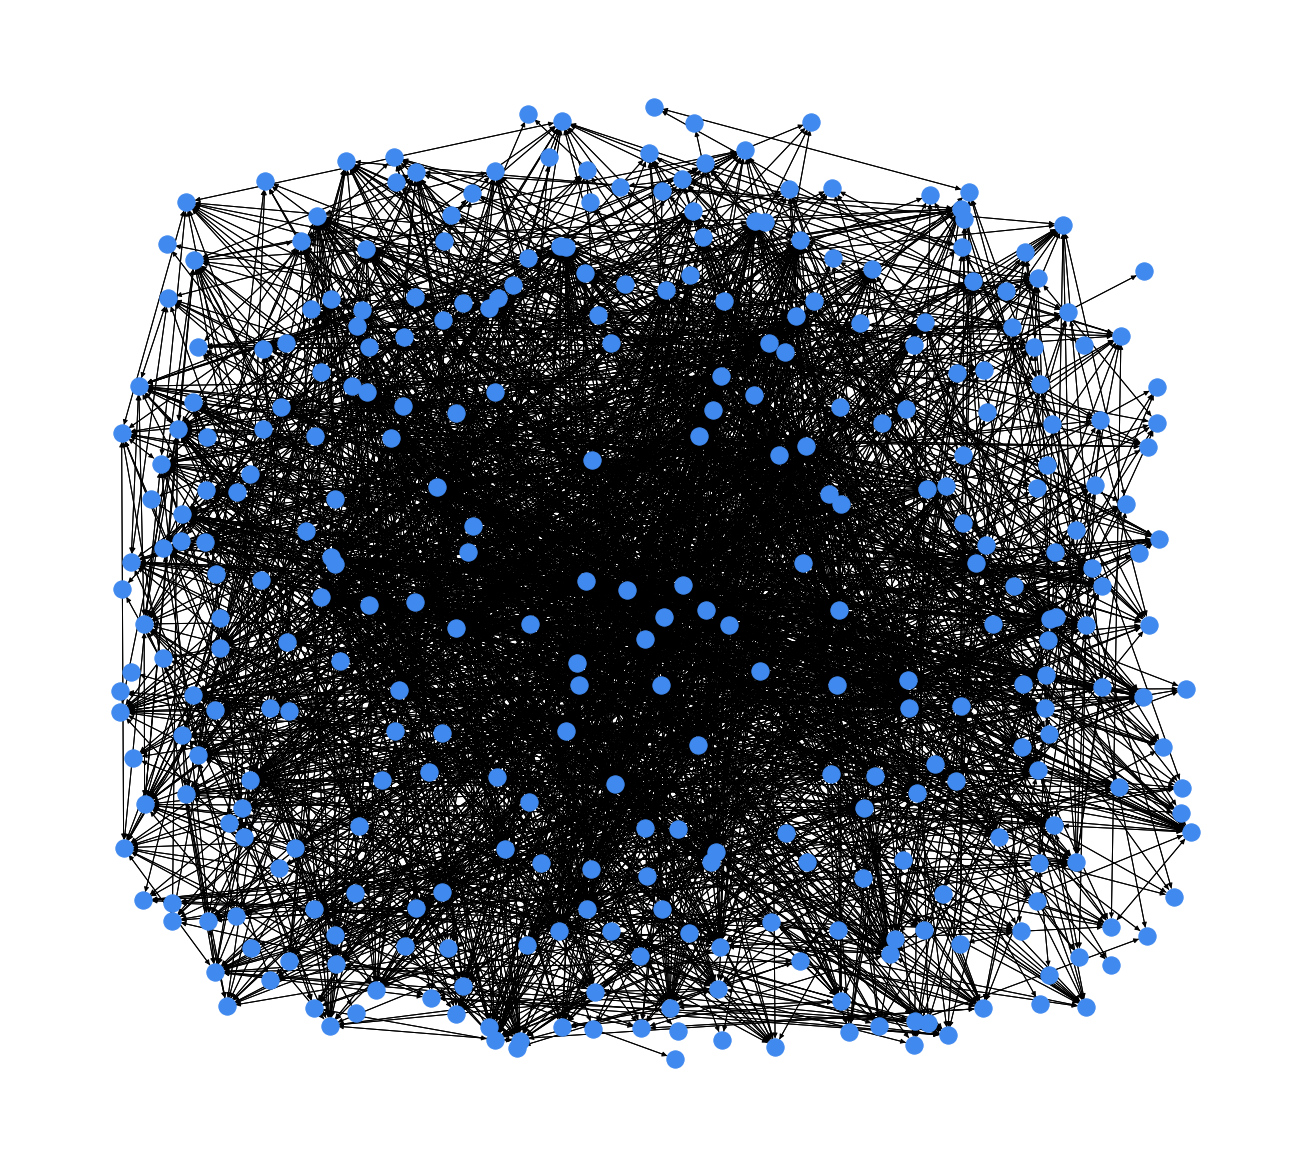

In [1]:
import networkx as nx, numpy as np, pandas as pd, statsmodels.api as sm, matplotlib.pyplot as plt

# read in the structure
file = 'SocialGraph_v2.0.gml'
file = 'SocialGraph_v3.0.gml'
g = nx.read_gml(file, label='id')


# formatting the graph and applying spring layout
fig=plt.figure(figsize=(18, 16))

pos=nx.spring_layout(g, k=0.4, iterations=5)

visual_style = {
    "node_size": 300,
    "node_color": "#4089EF",
    "bbox" : (700,700), 
    "with_labels" : False,
}

nx.draw(g, pos, **visual_style)


**TODO: Write your observations and ideas here**

* Description: The graph is very dense, so no real relationships are recognizable. Each node represents a person and the edge between two persons represents their relationship, which is characterized by several features. Most important is the tie strength which gives an idea if the persons are friends. And as friendship is a two sided relationship and varies per person, the graph is directed. 

* Ideas: One problem is that besides a dense social network, nothing can be seen from the graph. Therefore it would make sense to reduce the size of the displayed graph. One variant is to identify cliques and display them as one node and have an interactive possibility to get the subgraph of a clique to further understand the social network. Another variant would be to select some random nodes and only display those. However this could also lead to different insights depending on which nodes get selected. Lastly, one could use an interactive 3D representation and/or use colors/colormaps to enable more insights. I.e. different colors for cliques, and a colormap for edges depending on the tie strength. 

### b) Complete and convert the data

To further work with our data set, we will now convert it to a [Pandas](https://pandas.pydata.org/docs/user_guide/index.html) [4] dataframe. 
Some of our predictive variables are not yet computed in the _gml_ file, therefore you have to **calculate the missing variables** from the graph's attributes. You can take a look at the _gml_ file as it is human-readable to see what variables are available for you.

In [2]:
# Calculates the missing values for current edge e of graph g
def calculate_missing_variables(g, e):
    # the both nodes connected by edge e
    first, second = e
    # edge data such as firstComm and tieStrength
    edge_data = g.get_edge_data(first, second)
    
    # Source and target nodes for current edge
    src = g.nodes[first]
    tgt = g.nodes[second]
        
    # Already existing variables
    days_last_comm = edge_data['lastComm']
    photos_together = edge_data['photosTogether']
    wall_intim_words = edge_data['wallIntimWords']
    inbox_intim_words = edge_data['inboxIntimWords']
    days_first_comm = edge_data['firstComm']
    
    # The Ground Truth
    tie_strength = edge_data['tieStrength']

    
    # TODO: Compute the missing values
    age_dist = abs(src["age"]-tgt["age"]) #TODO take age number of node? take difference of ages of nodes?
    edu_diff = abs(src["numAcDegrees"] - tgt["numAcDegrees"]) #TODO # numAcDegrees?
    num_friends = g.out_degree(first) #TODO get out degree of node?
    friends_num_friends = g.out_degree(second) #TODO friends of friends?
    num_mutual_friends = len(set(g.neighbors(first)).intersection(set(g.neighbors(second)))) #TODO get number of friends that have "undirected edges"
    
    
    # Create row for dataframe
    row = [num_friends, friends_num_friends, days_last_comm, photos_together, wall_intim_words, inbox_intim_words, days_first_comm, num_mutual_friends, age_dist, edu_diff]
    row = [int(attr) for attr in row]
    row.append(tie_strength) # Appended separately, needs to be float
    
    return row


# Training and prediction lists
train_list = []
pred_list = []
cols = ['#Friends', 'Friends\' #Friends', '#Days Since Last Comm', '#Photos', '#Wall Intimacy Words', '#Inbox Intimacy Words', '#Days Since First Comm','#Mutual Friends', 'Age Dist', 'Educational Diff', 'Tie Strength']

# Calculate rows (one for each edge) and add them to tables

for e in g.edges:
    row = calculate_missing_variables(g, e)
    
    first, second = e
    edge = g.get_edge_data(first, second)
    
    if edge['tieStrength'] != -1:
        train_list.append(row)
    else:
        pred_list.append(row)
        
# Create training and prediction tables
train_table = pd.DataFrame(train_list, columns=cols)
pred_table = pd.DataFrame(pred_list, columns=cols)
train_table.head(10)

#Friends  Friends' #Friends  #Days Since Last Comm  #Photos  \
0        16                 21                    106        0   
1        16                 30                    197        3   
2        16                  7                     42        1   
3        16                  9                     72        7   
4        16                 19                     83        4   
5        16                 20                     77        1   
6        16                 61                    276        6   
7        16                  6                     48        0   
8        16                 17                     43        9   
9        16                 18                    266        3   

   #Wall Intimacy Words  #Inbox Intimacy Words  #Days Since First Comm  \
0                     8                     24                     245   
1                     8                     13                     436   
2                    11                     11                     297   
3                    21                     18                     255   
4                     7                     33                     362   
5                     8                     46                     247   
6                    14                      5                     449   
7                     5                     15                     287   
8                    25                     15                     302   
9                    12                      9                     321   

   #Mutual Friends  Age Dist  Educational Diff  Tie Strength  
0                8        27                 1      0.435982  
1                9        26                 0      0.520420  
2                3        23                 0      0.520384  
3                4        14                 0      0.552931  
4                6        21                 0      0.530087  
5                4        27                 0      0.550754  
6                3        14                 1      0.426431  
7                4        22                 0      0.480201  
8                4         8                 0      0.589384  
9                4         3                 1      0.428290

In [3]:
from sklearn.model_selection import train_test_split

if file == "SocialGraph_v3.0.gml":
    X = train_table.drop("Tie Strength", axis=1)
    y = train_table["Tie Strength"]
    train_feat, pred_feat, train_labels, pred_labels = train_test_split(X,y, test_size=0.3, random_state=42)

    train_table = pd.concat([train_feat, train_labels], axis=1)
    pred_table = pd.concat([pred_feat, pred_labels], axis=1)

### c) The Variance Inflation Factor (VIF)
Multiple linear regression can hold some pitfalls if you do not evaluate your data beforehands. Such a pitfall is containing multicollinearity in your predictive variables. 

Find out and **explain** in your own words what multicollinearity is, why it forms a danger to linear regression models and how the VIF is linked to that. 
**Create** a temporary dataframe containing only the predictive variables and **add a constant value** to the dataframe for the VIF to produce representative values. Then **compute the VIFs** for them. Statsmodels `variance_inflation_factor()` and `add_constant()` will help you with that. 

Additionally **explain**: What do the results tell you? Do we have to make any adaptions deriving from them?

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

# TODO: Create a dataframe, add a constant & compute VIF
temp_df = train_table.copy()
temp_df = add_constant(temp_df)
vif = pd.Series([variance_inflation_factor(temp_df.values, i) 
               for i in range(temp_df.shape[1])], 
              index=temp_df.columns)
vif

const                     195.542463
#Friends                    2.308181
Friends' #Friends           1.850351
#Days Since Last Comm       2.100425
#Photos                    11.965112
#Wall Intimacy Words       12.973265
#Inbox Intimacy Words       1.073341
#Days Since First Comm      3.148123
#Mutual Friends             3.495862
Age Dist                    1.008203
Educational Diff            1.497141
Tie Strength                3.534343
dtype: float64

**TODO: Write your explanaitions here**

*Multicollinearity:
This means that features are linearly dependent or close to linearly dependent. However an assumption of linear regression modelling is that the data is iid (independent and identically distributed). Therefore, this assumption is violated by multicollinearity and reduces the models ability. Moreover, this tells us that a feature can be expressed with some other features and making the linear dependent features useless.

*Problem: Multicollinearity can cause the method of estimating the regression coefficients to become unstable, hence making the predictive accuracy unprecise. Additionally, multicollinearity induces problems for interpreting the model. Reducing the dependent variables can solve this problem.

*VIF: The variance inflation factor measures how much the variance of a regression coefficient is increased because of multicollinearity. With that it gives an indication whether some variable is subject to multicollinearity and should be removed. The most common threshold for VIF are 5 or 10. 

*Interpretation: When using the threshold of 5, recommended by the library of the VIF, two columns need to be removed: For v2.0 of the graph: the column #Friends and Friends' #Friends has to be removed and for v3.0 the column #Photos and #Wall Intimacy Words has to be removed. s they are slighlty multicollinear. Other than that for v2.0 the Tie Strength has a high value which is nice because it is actually our dependent variable and means that we should be able to get a good prediction for it. 
Overall, the solution is to remove the two columns with a VIF > 5 and predict the tie strength.
For v2.0 the values are only slightly higher than 5, therefore another solution could be to stick with all features if the accuracy can be improved.

In [5]:
# drop the columns with VIF > 5
train_df = train_table.drop(["#Friends", "Friends' #Friends"], axis=1, inplace=False)
train_df2 = train_table.drop(["#Photos", "#Wall Intimacy Words"], axis=1, inplace=False)
#train_table = train_df2

### d) Log-Transformation
In data analysis, transformation is the replacement of a variable by a function of that variable. For example, replacing a variable $x$ by its square root $\sqrt{x}$ or its logarithm $\log{x}$. In a stronger sense, it means a replacement that changes the shape of a distribution or relationship. There are many reasons for transformations. The following list are a few of them but it is not comprehensive:

1. Convenience
2. Reducing skewness
3. Equal spreads
4. Linear relationships
5. Additive relationships

If you are looking at just one explanatory variable, points 1, 2 and 3 are relevant. But considering two or more variables, points 4 and 5 are more important. However, transformations that achieve 4 and 5 very often fulfill 2 and 3 as well.

In our case, a logarithmic transformation on the predictive variables will be used. It will help us to minimize the impact of any non-linearity on our model.

With the help of numpy's `log` function, **apply the log-transformation on each feature vector for the training table (but not the Tie Strength)**. Pay attention to the fact that $\log{0}$ is not defined, a small number (e.g. 0.000001) should be added before the transformation! Again, output the first ten entries of your dataframe.

In [6]:
# TODO: Apply log transformation
def apply_trafo(df, fun=np.log):
    tie_strength = df["Tie Strength"]
    df = df.transform(fun, axis=1)
    df["Tie Strength"] = tie_strength
    return df

train_table += 0.000001 
train_table = apply_trafo(train_table)
train_table.head(10)

#Friends  Friends' #Friends  #Days Since Last Comm       #Photos  \
4834  3.737670e+00           3.828641               3.433987 -1.381551e+01   
2348  3.806663e+00           2.564949               3.931826  2.197225e+00   
30    2.772589e+00           2.564949               5.429346  2.197225e+00   
725   9.999995e-07           1.386295               5.081404 -1.381551e+01   
2974  2.833213e+00           3.135494               3.178054  1.386295e+00   
2133  2.944439e+00           3.871201               4.672829 -1.381551e+01   
3970  3.737670e+00           3.850148               4.718499  1.609438e+00   
1426  2.708050e+00           3.688879               3.970292  9.999995e-07   
4848  3.295837e+00           4.025352               5.081404  2.944439e+00   
436   4.204693e+00           3.135494               4.356709  2.397895e+00   

      #Wall Intimacy Words  #Inbox Intimacy Words  #Days Since First Comm  \
4834              2.564949               3.871201                5.433722   
2348              3.044522               2.890372                5.476464   
30                2.995732               2.564949                5.872118   
725               1.386295               0.693148                5.575949   
2974              2.639057               2.197225                5.111988   
2133              1.386295               3.044522                5.420535   
3970              2.302585               3.044522                5.545177   
1426              2.079442               2.890372                6.274762   
4848              3.583519               2.833213                6.893656   
436               2.944439               2.397895                5.723585   

      #Mutual Friends  Age Dist  Educational Diff  Tie Strength  
4834         2.995732  0.693148     -1.381551e+01      0.525604  
2348         2.302585  1.386295      6.931477e-01      0.509392  
30           1.609438  2.079442      9.999995e-07      0.552717  
725        -13.815511  0.693148      9.999995e-07      0.443239  
2974         2.397895  1.609438     -1.381551e+01      0.531711  
2133         2.197225  0.693148      9.999995e-07      0.410522  
3970         3.178054  2.397895      9.999995e-07      0.515530  
1426         1.609438  2.197225      9.999995e-07      0.510506  
4848         2.833213  1.609438     -1.381551e+01      0.698947  
436          2.890372  0.693148      9.999995e-07      0.451778

## Task 4.2: The Regression Model

### a) Building the model
**1.**
Finally, the regression can be applied on the dataframe. For this purpose, **split** the dataframe into `y`: the target variable and `X`: the predictive variables. As you have read above, our model contains a bias/intercept named $\alpha$. This will be realized in the model by adding a constant (1.0), that gets multiplied with its own coefficient and therewith forms the intercept. It represents the target value when all explanatory variables are zero. Once again `add_constant(X)` will be of use.

**Split** the dataframe, **add** the constant and then **apply** a multiple linear regression on the training table, the statsmodels functions `OLS()` and `fit()` will help you with that. Output the summary with `model.summary()`.

In [7]:
# TODO: Add constant & build the regression model

y = train_table["Tie Strength"]
X = train_table.drop("Tie Strength", axis=1)
X = add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Tie Strength   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     421.6
Date:                Wed, 16 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:50:36   Log-Likelihood:                 6215.9
No. Observations:                3526   AIC:                        -1.241e+04
Df Residuals:                    3515   BIC:                        -1.234e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0835      0.009      8.879      0.000       0.065       0.102
#Friends                  -0.0139      0.001    -14.109      0.000      -0.016      -0.012
Friends' #Friends          0.0109      0.001     11.094      0.000       0.009       0.013
#Days Since Last Comm     -0.0197      0.001    -16.246      0.000      -0.022      -0.017
#Photos                   -0.0008      0.000     -5.009      0.000      -0.001      -0.000
#Wall Intimacy Words       0.0505      0.002     32.203      0.000       0.047       0.054
#Inbox Intimacy Words      0.0135      0.001     11.981      0.000       0.011       0.016
#Days Since First Comm     0.0608      0.002     35.887      0.000       0.057       0.064
#Mutual Friends            0.0011      0.000      3.654      0.000       0.001       0.002
Age Dist                4.897e-05      0.000      0.224      0.822      -0.000       0.000
Educational Diff          -0.0028      0.000    -27.113      0.000      -0.003      -0.003
==============================================================================
Omnibus:                       33.841   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.151
Skew:                           0.052   Prob(JB):                     2.87e-12
Kurtosis:                       3.592   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**2.**
As you can see the model's summary provides us with a multitude of informations about its performance. Now we need to evaluate our model based on these values. Find out what the meaning of the following statistics are: `R-squared`, `Adj. R-squared`, `Prob (F-statistic)`, the predicitve variables' significances `P>|t|`. [This site](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/multiple-regression/interpret-the-results/key-results/) [5] does a good job explaining them intuitively.

**Evaluate** our model's performance by giving a short comment on the obtained values for them. Don't write more than 5 sentences!


**TODO: Write your evaluation here!**

* R²: explains how much variation of the dependent variable, in our case tie strength, is captured by the model. The higher, the better. Here, 54% is explained by the model.

* R² adjusted: The usual R² is most helpful for models with the same number of features because adding a new feature would improve the R² value, but is not always good. To compare models of different size, the adjusted R² can be used, to really decide which is the best model.

* Prob F-statistic: gives the probability that the null hypothesis is true. A small value, as in our case, is good because it means that the null hypothesis is not true and our model learned sth reasonable. To be precise, the null hypothesis states that all coefficients are 0 and by having a small Prob F value this is refuted.

* P > |t|: The p values tell how important/significant each feature is. A value close to 0 means, that it is relevant, meaning that in our case all features except age distance are relevant.

**3.**
Now additionally **compare** the obtained coefficients `coef` for our predictive variables to the findings of the paper referenced in [1]. Wich kind of variables (Intimacy, Duration, Structural, Social distance) have the most influence on the Tie Strength according to our regression? You can also comment on specific predicitive variables' values. Keep in mind that the paper's coefficients are already standardized regarding the variabe's values, while ours do not yet compensate for them. Don't write more than 5 sentences.

**TODO: Write your observations here!**

From paper:
* I Intimacy: #Friends, Friends' #Friends, last comm, intimacy words
* D Duration: first comm
* S Structural: #mutual friends, common groups
* SD Social Distance: age diff, educational diff, religion, political diff

Our variables:
* I #Friends:	            -0.0139
* I Friends' #Friends:      0.0109
* I #Days Since Last Comm:	-0.0197
* I #Photos:	            -0.0008
* I #Wall Intimacy Words:	0.0505		
* I #Inbox Intimacy Words:	0.0135
* D #Days Since First Comm:	0.0608	
* S #Mutual Friends:	    0.0011
* SD Age Diff:	            4.897e-05		
* SD Educational Diff:	    -0.0028	

* Observation: The most important groups are the Intimacy and the durations group. Firstly because 70% of our predictive variables are from these groups, but more importantly do the values show, that the two contribute to the prediction the most. Especially the duration of the "friendship" and the intimacy of the words tell how strong the connection between two persons is. Structural and Social Distance factors don't play a role in the prediction, a similar thing is shown in the paper, where intimacy also plays the most important role, however duration is only slightly better than social distance factors. But structural features also remain unimportant.

### b) OPTIONAL: Goodness of Fit
After you have now analyzed some of the statistics of our model, there are some additional methods of analyzing the Goodness of Fit of our model. There are several methods to evaluate the Goodness of Fit of a regression. In this exercise, you will work with two of them: the Q-Q Plot and the Residual Plot.

**1.: Q-Q Plot**

Create a Q-Q Plot and evaluate what the result means for your fit. Plot the model's residuals on one axis and the normal distribution on the other axis, `scipy.stats` will provide it to you. What does the result tell you regarding your fit? Don't write more than 4 sentences.

**Hint:** Statsmodles offers a function for Q-Q Plots.

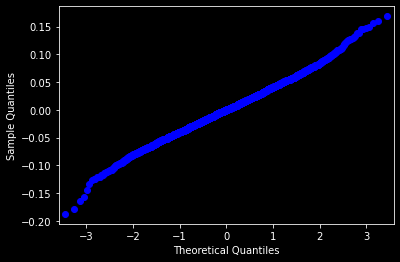

In [8]:
import scipy.stats as stats

# TODO: Create the QQ-Plot
residuals = model.resid
fig = sm.qqplot(residuals)
plt.show()


**TODO: Write your interpretation here!**

The graph shows that the data is evenly distributed, meaning there are no tails or skews in the data distribution. As it is plotted against a normal distribution, this tells us that the samples follow the same distribution and that our model fits the data quite nicely. Only on the bottom left are some unregular points.

**2.: Residual Plot**

Now evaluate your fit by plotting the residuals with matplotlib. The plot should show the standardized residuals for each entry. What does the result tell you regarding your fit? Don't write more than 4 sentences.

**Hint:** The standardized residuals can be accessed via `model.resid_pearson`.

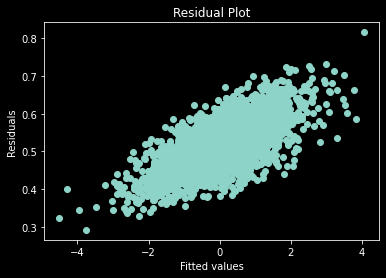

In [9]:
# TODO: Create the Residual-Plot
plt.scatter(model.resid_pearson,y)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


**TODO: Write your interpretation here!**

The assumptions is that the residuals are randomly distributed. However in our case the plot looks like a gaussian distribution, hence there seems to be a relation. This dependence in the residuals shows that our model doesn't meet the assumptions and isn't adequate, which could be because we use way less features than the model presented in the paper.

## Task 4.3: Prediction of Tie Strengths
As a last step, the missing tie string values (marked with -1) for the entries contained in the `pred_table` should be predicted using the before computed regression model. **Use the regression model to predict the missing Tie Strength values.** Statsmodels will be of help with that. **Remember** that we transformed the training data with a log-transform and added an intercept, so this needs to be done here as well. Output the first ten entries.

In [10]:
# TODO: Perform log transformation, add constant & predict the Tie Strengths
pred_table += 0.000001
pred_table = apply_trafo(pred_table)
X_pred = pred_table.drop("Tie Strength", axis=1)
# X_pred.drop(["#Friends", "Friends' #Friends"], axis=1, inplace=True)
# X_pred.drop(["#Photos", "#Wall Intimacy Words"], axis=1, inplace=True)
X_pred = add_constant(X_pred)

y_pred = model.predict(X_pred)
pred_table["Tie Strength predicted"] = y_pred
pred_table.head(10)
# An example for queries:
# pred_table[pred_table['Tie Strength'] > 0.7].head(5)

#Friends  Friends' #Friends  #Days Since Last Comm       #Photos  \
4793  2.944439           4.025352               5.411646  1.609438e+00   
3238  3.583519           4.219508               4.820282 -1.381551e+01   
2833  4.025352           2.833213               5.598422  2.302585e+00   
3048  2.079442           2.197225               4.007333  1.609438e+00   
3309  4.060443           2.639057               3.931826  6.931477e-01   
3418  2.995732           2.890372               5.257495  9.999995e-07   
240   2.639057           1.609438               4.574711  2.564949e+00   
4823  3.737670           4.025352               3.044522 -1.381551e+01   
2699  2.890372           3.044522               4.653960  6.931477e-01   
239   2.639057           3.135494               4.356709  6.931477e-01   

      #Wall Intimacy Words  #Inbox Intimacy Words  #Days Since First Comm  \
4793              2.772589               3.295837                6.366470   
3238              1.791760               3.044522                6.011267   
2833              3.295837               2.772589                6.418365   
3048              2.564949               2.564949                5.416100   
3309              2.197225               2.197225                5.153292   
3418              2.302585               2.772589                6.226537   
240               3.135494               3.178054                6.300786   
4823              1.609438               3.044522                4.624973   
2699              2.197225               2.079442                5.860786   
239               2.564949               2.833213                5.323010   

      #Mutual Friends   Age Dist  Educational Diff  Tie Strength  \
4793         2.708050   2.197225     -1.381551e+01      0.658550   
3238         3.044522   2.995732      9.999995e-07      0.503376   
2833         2.564949   1.945910      9.999995e-07      0.554114   
3048         1.945910   2.564949     -1.381551e+01      0.480568   
3309         2.197225   1.098613      9.999995e-07      0.432623   
3418         1.609438 -13.815511      6.931477e-01      0.500369   
240          1.386295   2.484907      9.999995e-07      0.548382   
4823         3.218876   0.693148     -1.381551e+01      0.551263   
2699         2.564949   2.079442     -1.381551e+01      0.503488   
239          2.197225   1.609438      6.931477e-01      0.447335   

      Tie Strength predicted  
4793                0.592304  
3238                0.496170  
2833                0.543345  
3048                0.533136  
3309                0.434221  
3418                0.501166  
240                 0.558175  
4823                0.472611  
2699                0.521641  
239                 0.486530

In [13]:
inv_df = pred_table.dropna()
inv_df[inv_df['Tie Strength predicted'] > 0.7].head(5)

Empty DataFrame
Columns: [#Friends, Friends' #Friends, #Days Since Last Comm, #Photos, #Wall Intimacy Words, #Inbox Intimacy Words, #Days Since First Comm, #Mutual Friends, Age Dist, Educational Diff, Tie Strength, Tie Strength predicted]
Index: []

In [12]:
inv_df[inv_df['Tie Strength predicted'] < 0.3].head(5)

Empty DataFrame
Columns: [#Friends, Friends' #Friends, #Days Since Last Comm, #Photos, #Wall Intimacy Words, #Inbox Intimacy Words, #Days Since First Comm, #Mutual Friends, Age Dist, Educational Diff, Tie Strength, Tie Strength predicted]
Index: []

**Are the predictions in line with the observations above? Pick a few entries to back up your observations.** If you would like to talk about other than the first ten entries, you can query a pandas dataframe similar to SQL. More information on how to do this is available in the [pandas documenation](https://pandas.pydata.org/pandas-docs/version/0.19.2/comparison_with_sql.html) [4].

As you might discover, there are some Tie Strength values slightly below zero. Can you **explain** that behaviour?

**TODO: Write your observation and explanation here!**

For some values the prediction of the tie strength is very good, others have a small error. So overall the prediction seems reasonable. However, when investigating the values by queries, one can find that ...

## References

[1] E. Gilbert and K. Karahalios: _Predicting Tie Strength With Social Media_. Proceedings of the SIGCHI Conference on Human Factors in Computing Systems. ACM, 2009.
<br>[2] C. Bishop: _Pattern Recognition and Machine Learning_. 2006.
<br>[3] https://www.moodle.tum.de/
<br>[4] https://pandas.pydata.org/docs/user_guide/index.html
<br>[5] https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/multiple-regression/interpret-the-results/key-results/